# National assembly minutes(NAM) preprogressing
- raw_txt to data_tsv

### 국회 회의 데이터 전처리
- 한글파일(HWP)에서 추출한 텍스트 파일 전처리
- 아래의 전처리 순서를 지켜야함

---

- 텍스트 배열 추출(라인별)

---

- 라인별 전처리
```
 - '^\n' : 공백 라인 삭제
 - 'o' : 소문자 영어o를 이용한 단락 설명 삭제 (ex: o 국무위원 인사) 
```

---

- 텍스트 배열 to 텍스트 문자열로 변환

---

- 회의시작 전과 후 데이터 삭제
```
 - '\(\d+?[월시]\d+?[일분]\s.+?\)'가 처음 등장하는 부분이 시작
 - '\(\d+?[월시]\d+?[일분]\s.+?\)'가 마지막 등장하는 부분이 종료
```

---

- 대화가 아닌 내용 삭제
```
 - '(\(.+\))' : 괄호 데이터 삭제
 - '\d+\.\s[^◯]*' : 회의 안건 목록 삭제
```

---

- 시간에 따른 화자별 대화로 구분
```
 - '◯.+?\s.+?\s+' : 화자 추출
 - 화자 시퀀스와 대화 시퀀스
```

---

- 화자별 대화 문단 정제
```
 - '\n' 줄바꿈 기호 삭제
 - 앞뒤 공백제거
 - '\s{2,}' 두 개 이상의 띄어쓰기 한 개로 변경
 - '\s$' 문단 마지막에 있는 띄어쓰기 삭제
 - 연속된 명사 사이에 찍히는 '․'(마침표 아님)를 ', '로 변경
```

---

- 문단으로 부터 문장 추출
```
 - 앞뒤 공백제거
 - '\s?(.+?[\.\!\?…])\D' : 문장 추출
```

In [1]:
from utils import logger
import os, re, time, csv

RAW_TXT_PATH = '../crawling/raw_txt/'
TSV_PATH = './data/data_tsv/'

# Get file name list from PATH
#
# [return]
# - 파일이름 목록 : list(file)
# - 총 파일 개수 : int(fileListNum)
def getfileList(path):
    # Create the path if it does't exist.
    if not os.path.exists(path):
        os.makedirs(path)

    fileList = os.listdir(path)
    fileList.sort()
    
    # There is '.DS_Store' file in Mac OS
    if '.DS_Store' in fileList:
        fileList.remove('.DS_Store')
        
    fileListNum = len(fileList)
    return fileList, fileListNum


# Get raw text array sperated by line from file
#
# [return]
# - 라인 별 문자열 : list(line)
def getRawTextArray(file):
    logger.i("파일 이름 : {}".format(file))
    rawTextArray = []
    with open(RAW_TXT_PATH + file, 'r') as f:
        for line in f.readlines():
            rawTextArray.append(str(line))
    return rawTextArray


# Get text array from rawTextArray
#
# [return]
# - 정제된 라인 별 문자열 : list(line)
def getTextArray(rawTextArray):
    textArray = []
    for rawText in rawTextArray:
        # Except empty line
        if re.match('^\n', rawText):
            continue
    
        # Except descrpition of paragraph
        if re.match('^o\s', rawText):
            continue

        textArray.append(rawText)
    return textArray
    
        
# Get raw text from textArray
#
# [return]
# - 파일 문자열 : str(rawText)
def getRawText(textArray):
    rawText = ''.join(textArray)
    return rawText
    

# Get only minute text from rawText
# - 회의시작 전 데이터 삭제 : '\(\d+?시\d+?분\s[가-힣]+?\)'가 처음 등장하는 부분이 시작
# - 회의종료 후 데이터 삭제 : '\(\d+?시\d+?분\s[가-힣]+?\)'가 마지막 등장하는 부분이 종료
#
# [return]
# - 회의 문자열 : str(minute)
def getOnlyMinuteText(rawText):
#     splitRawTxt = re.split('\(\d+?시\d+?분\s[가-힣]+?\)', rawText)
    splitRawTxt = re.split('\(\d+?[월시]\d+?[일분]\s.+?\)', rawText)

    # If length of splitRawTxt is less than 2, it's not normal minute data.
    minute = None
    if len(splitRawTxt) < 3:
        logger.e('{}파일의 문단 경계가 {}개로 부족합니다.'.format(file, len(splitRawTxt)))
    else:
        return ''.join(splitRawTxt[1:-1])


# Get only conversation text
# - '(\(.+\))' : 괄호 데이터 삭제
# - '\n\d+\.\s[^◯]*' : 회의 안건 목록 삭제
#
# [return]
# - 대화 문자열 : str(conversation)
def getOnlyConvText(minuteText):
    minuteTextWithoutBracket = re.sub('(\(.+\))', '', minuteText)
    conversationText = re.sub('\d+\.\s[^◯]*', '', minuteTextWithoutBracket)
    return conversationText


# Seperate conversation by speaker
# - '◯.+?\s.+?\s+' : 화자 추출
#
# [return]
# - 시간 별 화자 목록 : list(list(speaker))
# - 화자 별 문단 목록 : list(paragraph)
def getSeperatedConvBySpeaker(convText):
    # 화자 시퀀스
    speakerSeq = re.findall('◯(.+?\s.+?)\s+', convText)
    
    # 대화 시퀀스
    convSeq = re.split('◯.+?\s.+?\s+', convText)
    
    # 0번째에 줄바꿈(\n) 문자밖에 없는 경우 제외
    if len(re.findall("\n", convSeq[0])) == len(convSeq[0]):
        convSeq = convSeq[1:]
        
    speakerSeqNum = len(speakerSeq)
    convSeqNum = len(convSeq)
    if speakerSeqNum == 0 or convSeqNum == 0:
        logger.e('대화가 존재하지 않습니다.')
    elif speakerSeqNum != convSeqNum:
        logger.e('화자 시퀀스({}개)와 대화 시퀀스({}개)의 개수가 다릅니다.'.format(speakerSeqNum, convSeqNum))
    else:
        logger.i('화자 시퀀스 수 : {} / 대화 시퀀스 수: {}'.format(speakerSeqNum, convSeqNum))
        return speakerSeq, convSeq
    

# Paragraph preprogressing
# - '\\n' 줄바꿈 기호 삭제
#
# - '\t' 탭 기호 띄어쓰기로 교체
#
# - '\xa0' 띄어쓰기처럼 생긴 아닌애 띄어쓰기로 교체
#
# - 앞뒤 공백제거
#
# - '\s{2,}' 두 개 이상의 띄어쓰기 한 개로 변경
#
# Option
# - '․' => ', '로 변경
#                                 
# [return]
# - 정제된 화자 별 문단 목록 : list(list(paragraph))
def getCleanParagraph(rawConvSeq):
    convSeq = []
    for conv in rawConvSeq:
        # remove the line break
        conv = re.sub('\\n', '', conv)
        
        # replace the \u3000 to spacing
        conv = conv.replace(u'\u3000', u' ')
        
        # replace \xa0 to spacing
        conv = conv.replace(u'\xa0', u' ')
        
        # remove first and last spacing
        conv = conv.strip()
        
        # replace two spacing  to one spacing
        conv = re.sub('\s{2,}', ' ', conv)
                    
        # change '……' to '…'
        conv = conv.replace('……', '…')
                                   
        # change '․' to ', ' (pandas)
        conv = re.sub('․', ', ', conv)
        
        # remove spacing at the end of a paragraph
        convSeq.append(re.sub('\s$', '', conv))
    return convSeq


# Get sentences from paragraph
# - 앞뒤 공백제거
# 
# [return]
# - 문장단위로 분리된 화자 별 문단 목록 : list(list(list(sententce)))
def getSeperatedParagraphBySentence(convSeq):
    sepConvSeq = []
    for conv in convSeq:
        sentences = re.findall('\s?(.+?[\.\!\?…])\D', conv)
        for idx, sentence in enumerate(sentences):
            sentences[idx] = sentence.strip()
        sepConvSeq.append(sentences)
    
    return sepConvSeq

    
# Remove contexts that are not typos or conversations
# - 뒤에서부터 수정
def removeNonConv(speakerSeq, sepConvSeq):
    sepConvSeqNum = len(sepConvSeq)
    for revIdx, paragraph in enumerate(reversed(sepConvSeq)):
        if len(paragraph) == 0:
            idx = sepConvSeqNum - revIdx - 1
            del speakerSeq[idx]
            del sepConvSeq[idx]
            
    speakerSeqNum = len(speakerSeq)
    sepConvSeqNum = len(sepConvSeq)
    if speakerSeqNum != sepConvSeqNum:
        logger.e('화자 시퀀스({}개)와 대화 시퀀스({}개)의 개수가 다릅니다.'.format(speakerSeqNum, sepConvSeqNum))
    else:
        return speakerSeq, sepConvSeq
    
    
# Save to TSV
# - str => unicode
def saveTSV(fileName, speakerSeq, sepConvSeq):
    # Create the path if it does't exist.
    if not os.path.exists(TSV_PATH):
        os.makedirs(TSV_PATH)
        
    f = open(TSV_PATH + fileName + '.tsv', 'w', encoding='utf-8', newline='')
    wr = csv.writer(f, delimiter='\t')
    # write header
    wr.writerow(["index", "speaker", "sentence"])
    
    # write data
    speakerSeqNum = len(speakerSeq)
    index = 0
    for i in range(speakerSeqNum):
        for j, sentence in enumerate(sepConvSeq[i]):
            wr.writerow([index, speakerSeq[i], sentence])
            index += 1
    f.close()

In [2]:
# 회의록 데이터 정제

start_time = time.time()

fileList, fileListNum = getfileList(RAW_TXT_PATH)
speakerList, convList = [], []

for idx, file in enumerate(fileList):
    
    logger.p(idx, fileListNum)
    fileName = file.split('.')[0]
#     if os.path.exists(TSV_PATH + fileName + '.tsv'):
#         continue
    
    # 텍스트 배열 추출(라인별)
    rawTextArray = getRawTextArray(file)
    
    # 라인별 전처리
    textArray = getTextArray(rawTextArray)
    
    # 텍스트 배열 to 텍스트 문자열로 변환
    rawText = getRawText(textArray)
    
    # 회의시작 전과 후 데이터 삭제
    minuteText = getOnlyMinuteText(rawText)
    
    # 대화가 아닌 내용 삭제
    convText = getOnlyConvText(minuteText)
    
    # 시간에 따른 화자별 대화로 구분
    speakerSeq, rawConvSeq = getSeperatedConvBySpeaker(convText)
    
    # 화자별 대화 문단 정제
    convSeq = getCleanParagraph(rawConvSeq)
    
    # 문단을 문장단위로 분리
    sepConvSeq = getSeperatedParagraphBySentence(convSeq)
    
    # 오타, 완벽하지 않은 문장, 비구어체 삭제
    speakerSeq, sepConvSeq = removeNonConv(speakerSeq, sepConvSeq)

    # TSV로 저장
    saveTSV(fileName, speakerSeq, sepConvSeq)
    
    speakerList.append(speakerSeq)
    convList.append(sepConvSeq)
    
print("소요시간 : {0:0.2f}초".format(time.time() -  start_time))

진행도 : 641/641 (100.00%)
'파일 이름 : 국회회의록_20대_367회_개회식_국회본회의.txt'
'화자 시퀀스 수 : 3 / 대화 시퀀스 수: 3'
소요시간 : 35.27초


# National assembly minutes(NAM) analysis
- nam_tsv analysis

### Analysis progress

---

- 특수문자가 들어간 문장 추출
 - 문장 추출
 - '[^a-zA-Z0-9가-힣\s\.\!\?]' : 한글, 숫자, 영어, \.(마침표), \!(느낌표), \?(물음표), \s(띄어쓰기)가 아닌 문자열이 포함된 문장 추출
 
---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get TSV file lilst
def getTsvList(path):
    # Create the path if it does't exist.
    if not os.path.exists(path):
        os.makedirs(path)

    tsvList = os.listdir(path)
    
    # There is '.DS_Store' file in Mac OS
    if '.DS_Store' in tsvList:
        tsvList.remove('.DS_Store')
        
    tsvList.sort()
    tsvListNum = len(tsvList)
    return tsvList, tsvListNum
    
def getTsv(path):
    if not os.path.exists(path):
        logger.e("\'{}\'가 존재하지 않습니다.".format(path))
    else:
        return pd.read_csv(path, delimiter='\t')

In [7]:
tsvList, tsvListNum = getTsvList(TSV_PATH)

corpus = pd.DataFrame(columns=["index", "speaker", "sentence"])
for idx, tsv in enumerate(tsvList):
    data = pd.read_csv(TSV_PATH + tsv, delimiter='\t', encoding='utf-8', header=0)
    corpus = corpus.append(data, ignore_index=True)
    logger.p(idx, tsvListNum)

print(corpus.size)

진행도 : 641/641 (100.00%)
2084007


In [27]:
corpus.sample(10)

,index,speaker,sentence
23090,1037,보건복지부기획조정실장 김강립,먼저 뒤의 부분부터 말씀을 드리면 결국 자료 14페이지에 있듯이 환자의 안전에 관한...
353432,1934,이원욱 위원,제가 말씀드린 게 아니고요 내년도조차도 경기전망을 낙관할 수 없는 상황이다라고 하는...
308801,2238,백승주 위원,"실장님, 하나 더 질문드릴게요."
501879,311,외교부장관 강경화,그 부분에 대해서 제가 답변드릴 준비가 안 돼 있음을 죄송스럽게 생각합니다.
179781,590,정양석 위원,한미 워킹그룹에 대해서 또 오늘 북한 매체가 ‘남북협력사업을 파탄 내려는 그런 것이...
31321,295,고용노동부장관 이재갑,원래 자신이 얘기한 것은 ‘비정규직은 총파업을 한다 하더라도 정규직은 하면 안 되는...
555083,2516,유민봉 위원,결국에는 역차별이 된 것이지요.
419573,1352,이춘석 위원,그리고 공소유지를 잘하고 있느냐?
610111,357,이장우 위원,그러다 보니까 산재가 발생되면 그것도 하도급 하는 사람들한테 떠밀고.
532513,787,소병훈 위원,그래서 이 부분은 단순히 정부 조직을 바꾼다 이런 차원이 아니고 국민의 안전을 지키...


### 각 문장의 문자 길이 분포

In [28]:
print('전체 학습데이터의 개수: {}'.format(len(corpus)))

전체 학습데이터의 개수: 694669


In [29]:
corpus_length = corpus['sentence'].apply(len)

In [30]:
corpus_length.head()

0     17
1     28
2     15
3     41
4    159
Name: sentence, dtype: int64

Text(0, 0.5, 'Number of sentence')

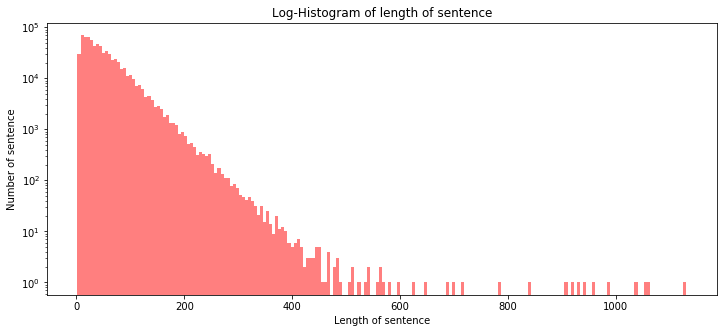

In [31]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(corpus_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of sentence')
# 그래프 x 축 라벨
plt.xlabel('Length of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [32]:
print('문장 길이 최대 값: {}'.format(np.max(corpus_length)))
print('문장 길이 최소 값: {}'.format(np.min(corpus_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(corpus_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(corpus_length)))
print('문장 길이 중간 값: {}'.format(np.median(corpus_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장 길이 제 1 사분위: {}'.format(np.percentile(corpus_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(corpus_length, 75)))

문장 길이 최대 값: 1131
문장 길이 최소 값: 2
문장 길이 평균 값: 49.34
문장 길이 표준편차: 40.68
문장 길이 중간 값: 38.0
문장 길이 제 1 사분위: 19.0
문장 길이 제 3 사분위: 67.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1358f4d68>,
 'caps': [<matplotlib.lines.Line2D at 0x135a0a438>,
 'boxes': [<matplotlib.lines.Line2D at 0x1358f4908>],
 'medians': [<matplotlib.lines.Line2D at 0x135a0aac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x135a0aeb8>],
 'means': [<matplotlib.lines.Line2D at 0x135a0ae10>]}

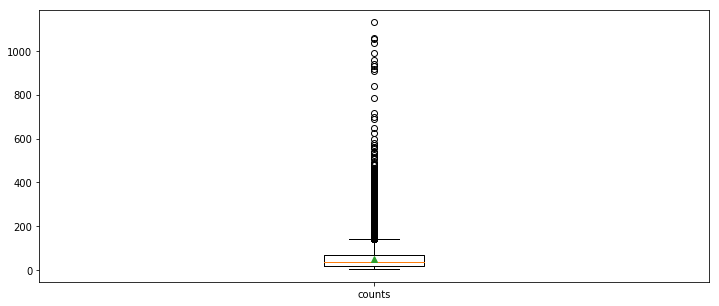

In [33]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(corpus_length,
             labels=['counts'],
             showmeans=True)

### 많이 사용된 단어

In [34]:
from wordcloud import WordCloud

(-0.5, 799.5, 599.5, -0.5)

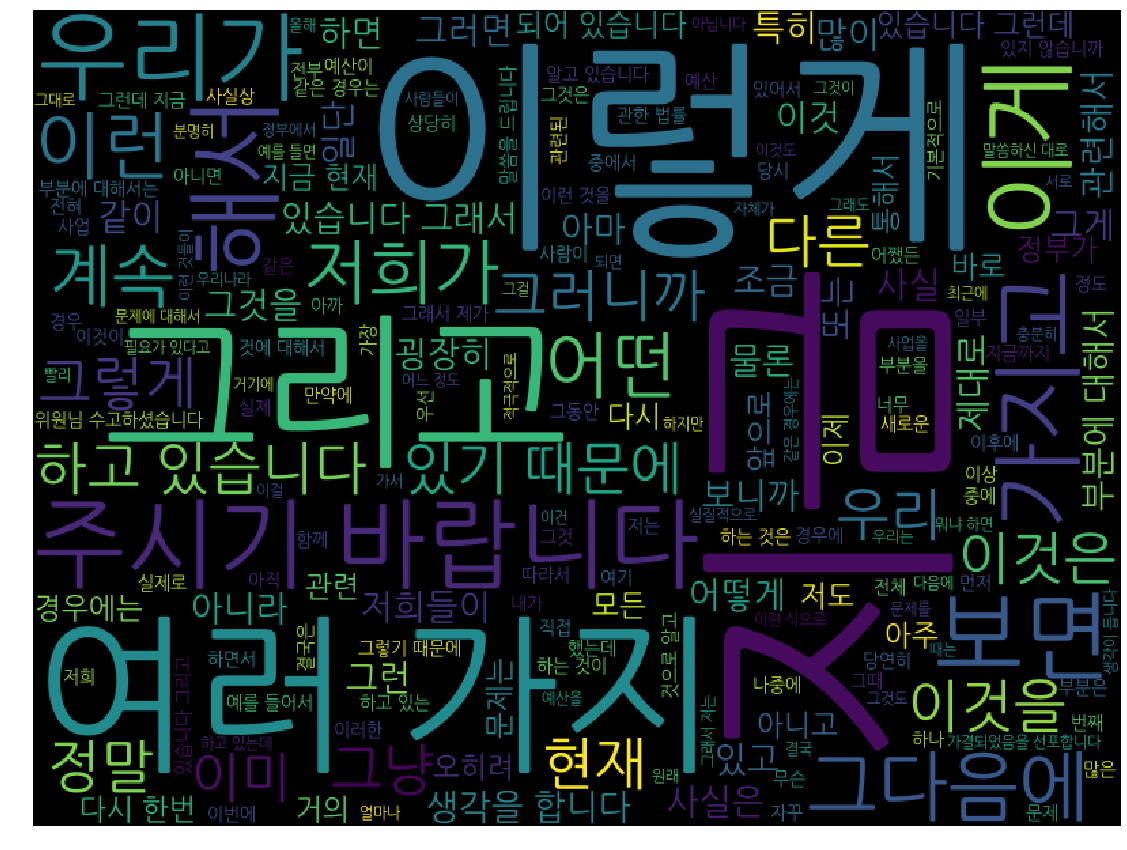

In [23]:
fontPath = "/Library/Fonts/NanumGothic.otf"
cloud = WordCloud(width=800, height=600, font_path=fontPath).generate(" ".join(corpus['sentence']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [35]:
corpus_word_counts = corpus['sentence'].apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of sentences')

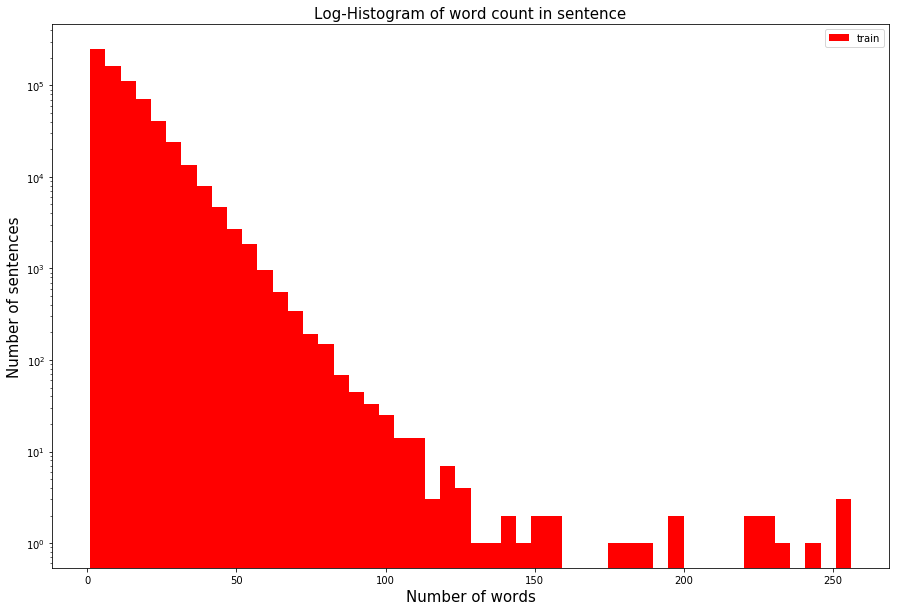

In [36]:
plt.figure(figsize=(15, 10))
plt.hist(corpus_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in sentence', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of sentences', fontsize=15)

In [37]:
print('단어 개수 최대 값: {}'.format(np.max(corpus_word_counts)))
print('단어 개수 최소 값: {}'.format(np.min(corpus_word_counts)))
print('단어 개수 평균 값: {:.2f}'.format(np.mean(corpus_word_counts)))
print('단어 개수 표준편차: {:.2f}'.format(np.std(corpus_word_counts)))
print('단어 개수 중간 값: {}'.format(np.median(corpus_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('단어 개수 제 1 사분위: {}'.format(np.percentile(corpus_word_counts, 25)))
print('단어 개수 제 3 사분위: {}'.format(np.percentile(corpus_word_counts, 75)))

단어 개수 최대 값: 256
단어 개수 최소 값: 1
단어 개수 평균 값: 11.89
단어 개수 표준편차: 10.00
단어 개수 중간 값: 9.0
단어 개수 제 1 사분위: 5.0
단어 개수 제 3 사분위: 16.0


### 특수문자 및 대, 소문자 비율

In [38]:
qmarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall('\?$', x)) > 0)) # 물음표가 구두점으로 쓰임
emarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall('\!$', x)) > 0)) # 느낌표가 구두점으로 쓰임
pmarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall('\.$', x)) > 0)) # 마침표가 구두점으로 쓰임
psmarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall('…$', x)) > 0)) # …가 구두점으로 쓰임
cmarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall(',', x)) > 0)) # ,가 있는 문장
spmarks = np.mean(corpus['sentence'].apply(lambda x: len(re.findall('[^가-힣a-zA-Z0-9\.\?\!\s]', x)) > 0)) # 특수문자가 있는 문장
                  
print('물음표로 끝나는 문장: {:.2f}%'.format(qmarks * 100))
print('마침표로 끝나는 문장: {:.2f}%'.format(pmarks * 100))
print('…로 끝나는 문장: {:.2f}%'.format(psmarks * 100))
print(',각 있는 문장 문장: {:.2f}%'.format(cmarks * 100))
print('특수문자가 있는 문장: {:.2f}%'.format(spmarks * 100))

물음표로 끝나는 문장: 11.44%
마침표로 끝나는 문장: 83.64%
…로 끝나는 문장: 4.64%
,각 있는 문장 문장: 30.27%
특수문자가 있는 문장: 36.72%
